#Procesamiento y utilización de grandes numeros de datos

Ernesto Reynoso Lizárraga A0139915

### Descarga y configuración de pyspark

In [4]:
!pip install pyspark py4j

  Using cached pyspark-3.5.0.tar.gz (316.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=7daba9cb8347101352d8420d3a8ad3ac7879ce8a1383c96d77cd2b24c92b2cd2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder.appName("tec").getOrCreate()

### Modelo de regresión lineal

In [7]:
entrenamientolr = spark.read.format("libsvm").load("/content/drive/MyDrive/Inteligencia Artificial/sample_linear_regression_data.txt")

Creamos el modelo

In [8]:
modelolr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

Ajustamos el modelo con los datos de entrenamiento

In [9]:
modelolr = modelolr.fit(entrenamientolr)

mostramos los coeficientes de las variables

In [10]:
print("Coeficientes: %s" % str(modelolr.coefficients))
print("beta0: %s" % str(modelolr.intercept))

Coeficientes: [0.0,0.3229251667740594,-0.3438548034562219,1.915601702345841,0.05288058680386255,0.765962720459771,0.0,-0.15105392669186676,-0.21587930360904645,0.2202536918881343]
beta0: 0.15989368442397356


Mostramos en una grafica de barras los valores de los coeficientes para ver su impacto en el modelo.

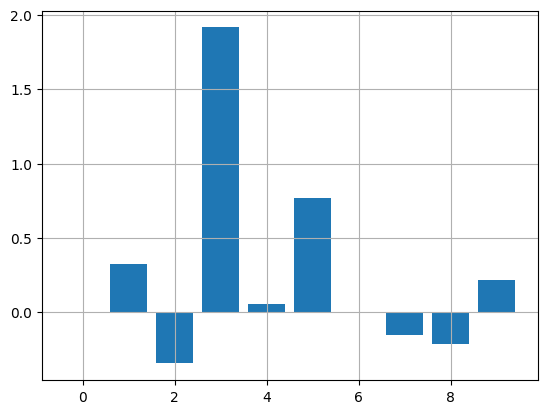

In [11]:
etiquetas = range(len(modelolr.coefficients))
plt.bar(etiquetas, modelolr.coefficients)
plt.grid()
plt.show()

mostramos la R^2 y la raiz del error cuadratico medio

In [12]:
print("RMSE: %f" % modelolr.summary.rootMeanSquaredError)
print("r2: %f" % modelolr.summary.r2)

RMSE: 10.189077
r2: 0.022861


### Modelo de Clasificación

Preparamos los datos

In [13]:
entrenamientoC = spark.read.format("libsvm").load("/content/drive/MyDrive/Inteligencia Artificial/sample_libsvm_data.txt")

Creamos el modelo

In [14]:
modeloC = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

Ajustamos el modelo a los datos

In [15]:
modeloC = modeloC.fit(entrenamientoC)

Mostramos los coeficientes de las variables

In [16]:
print("beta0: " + str(modeloC.intercept))
print("Coefficients: " + str(modeloC.coefficients))


beta0: -0.5991460286401438
Coefficients: (692,[272,300,323,350,351,378,379,405,406,407,428,433,434,435,455,456,461,462,483,484,489,490,496,511,512,517,539,540,568],[-7.520689871384125e-05,-8.115773146847006e-05,3.814692771846427e-05,0.0003776490540424338,0.0003405148366194403,0.0005514455157343107,0.0004085386116096912,0.0004197467332749452,0.0008119171358670031,0.000502770837266875,-2.3929260406600902e-05,0.0005745048020902297,0.0009037546426803677,7.818229700243899e-05,-2.1787551952911914e-05,-3.402165821789542e-05,0.0004966517360637633,0.0008190557828370372,-8.017982139522613e-05,-2.743169403783527e-05,0.0004810832226238988,0.0004840801762677878,-8.926472920009901e-06,-0.00034148812330427297,-8.950592574121382e-05,0.00048645469116892156,-8.478698005186097e-05,-0.00042347832158317705,-7.296535777631246e-05])


Realizamos una predicción

In [17]:
predicciones = modeloC.transform(entrenamientoC)

Mostramos la matriz de confusión

In [18]:
y_true = entrenamientoC.select("label").rdd.map(lambda row: row[0]).collect()
y_pred = predicciones.select("prediction").rdd.map(lambda row: row[0]).collect()

In [19]:
cm = confusion_matrix(y_true, y_pred)

Text(0.5, 1.0, 'Matriz de Confusión')

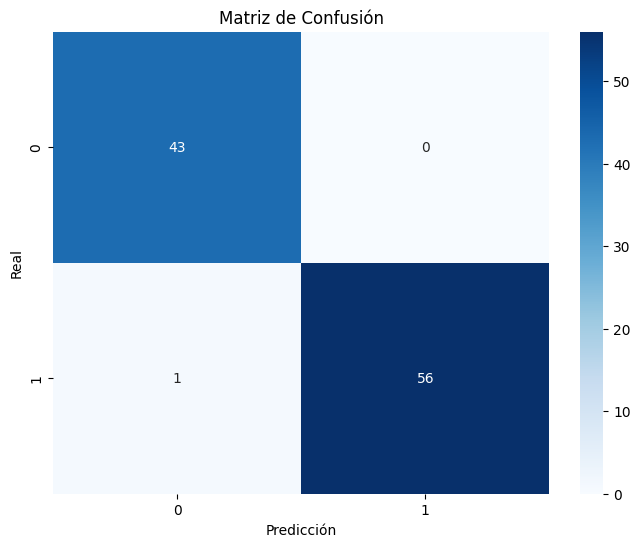

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True, cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')

##Modelo de Agrupamiento

Preparamos los datos

In [21]:
entrenamientoA = spark.read.format("libsvm").load("/content/drive/MyDrive/Inteligencia Artificial/sample_kmeans_data.txt")

Creamos el modelo ajustandolo a los datos

In [22]:
kmeans = KMeans()
modeloA = kmeans.fit(entrenamientoA)

Realizamos las predicciones con el modelo

In [23]:
predicciones = modeloA.transform(entrenamientoA)

Evaluamos las predicciones calculando el indice de silhouette

In [24]:
evaluacion = ClusteringEvaluator()
silhouette = evaluacion.evaluate(predicciones)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9997530305375207


Mostramos las coordenadas de los centros

In [25]:
centros = modeloA.clusterCenters()
print("Cluster Centers: ")
for centro in centros:
    print(centro)

Cluster Centers: 
[9.1 9.1 9.1]
[0.1 0.1 0.1]


En un grafico mostramos que tan separados estan los centros de los clusters

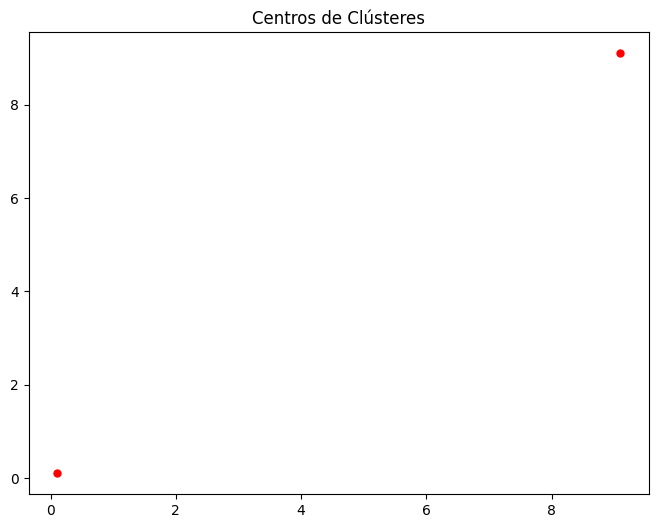

In [26]:
x_centros = [centro[0] for centro in centros]
y_centros = [centro[1] for centro in centros]

# Crea un gráfico de dispersión para visualizar los centros de los clústeres
plt.figure(figsize=(8, 6))
plt.scatter(x_centros, y_centros, c='red', marker='.', s=100)
plt.title('Centros de Clústeres')

# Muestra el gráfico
plt.show()